Prepare training/test dataset

In [1]:
import sys, os
import numpy as np
from struct import *
from collections import OrderedDict
from array import array
from struct import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import seaborn as sns
#train file
fp_image = open('train-images.idx3-ubyte','rb')
fp_label = open('train-labels.idx1-ubyte','rb')

#test file
fp_t_img = open('t10k-images.idx3-ubyte' ,'rb')
fp_t_lbl = open('t10k-labels.idx1-ubyte' ,'rb')


s = fp_image.read(16)    #read first 16byte    
l = fp_label.read(8)    #read first  8byte

st= fp_t_img.read(16)    #read first 16byte
sl= fp_t_lbl.read(8)    #read first  8byte

#파일 읽기에 필요한 변수들 설정
img = np.zeros(784)    #1d array (784 byte) - input data
r = np.zeros(10) # 정답이 저장되는 부분

x_train = []
t_train = []

x_test = []
t_test = []

print("read training data ")

#트레이닝 데이터 읽기
while True:
    img = fp_image.read(784)
    l = fp_label.read(1)
    
    if not img:
        break;
    if not l:
        break;

    x_train.append(unpack(len(img)*'B',img))
    t_train.append(int(l[0]))    

print("done")

#테스트 데이터 읽기
print("read test data ")
while True:
    img = fp_t_img.read(784)
    l   = fp_t_lbl.read(1)

    if not img:
        break;
    if not l:
        break;

    x_test.append(unpack(len(img)*'B',img))
    t_test.append(int(l[0]))

print("done")

#normalization
x_train = np.array(x_train)
x_train = (x_train/255.0)
t_train = np.array(t_train)
x_test = np.array(x_test)
x_test = (x_test/255.0)
t_test = np.array(t_test)

read training data 
done
read test data 
done


Design 3-layer Neural Network

In [2]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대비
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class ThreeLayerNN:

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, weight_init_std=0.02):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden1_size)
        self.params['b1'] = np.zeros(hidden1_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden1_size, hidden2_size)
        self.params['b2'] = np.zeros(hidden2_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden2_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers=OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return self.lastLayer.forward(y, t)

    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        #순전파
        self.loss(x,t)
        #역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
    
        return grads

implement training pipeline, train NN

In [3]:
network = ThreeLayerNN(input_size=784, hidden1_size=300, hidden2_size=100, output_size=10)

# 하이퍼파라미터
train_size = len(x_train)
test_size = len(x_test)
iters_num = 60000  
batch_size = 100   # 미니배치 크기
learning_rate = 0.5

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
# 1epoch당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    #미니배치 무작위 선정
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    batch_test_mask = np.random.choice(test_size, batch_size)
    x_test_batch = x_test[batch_test_mask]
    t_test_batch = t_test[batch_test_mask]
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    # acc 계산
    if i % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train, t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


train acc : 0.14633333333333334 / test acc : 0.1416
train acc : 0.9522166666666667 / test acc : 0.9502
train acc : 0.9776166666666667 / test acc : 0.9703
train acc : 0.9788166666666667 / test acc : 0.9714
train acc : 0.9854666666666667 / test acc : 0.9777
train acc : 0.9883833333333333 / test acc : 0.9768
train acc : 0.9916833333333334 / test acc : 0.9794
train acc : 0.9916333333333334 / test acc : 0.9788
train acc : 0.9941666666666666 / test acc : 0.9816
train acc : 0.9956666666666667 / test acc : 0.9819
train acc : 0.99745 / test acc : 0.9816
train acc : 0.9966166666666667 / test acc : 0.9808
train acc : 0.9989666666666667 / test acc : 0.983
train acc : 0.9987666666666667 / test acc : 0.9829
train acc : 0.9996666666666667 / test acc : 0.9845
train acc : 0.9998 / test acc : 0.9852
train acc : 0.9998833333333333 / test acc : 0.9842
train acc : 0.9999 / test acc : 0.9851
train acc : 0.9999833333333333 / test acc : 0.9847
train acc : 1.0 / test acc : 0.9845
train acc : 1.0 / test acc : 0

Test the NN, draw figures

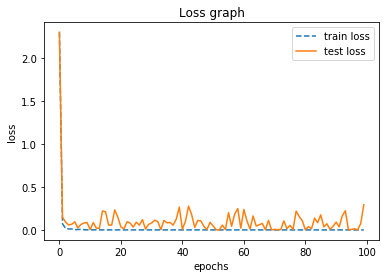

[[0.994 0.    0.001 0.001 0.001 0.001 0.    0.001 0.001 0.   ]
 [0.    0.993 0.001 0.001 0.    0.    0.002 0.    0.004 0.   ]
 [0.001 0.    0.984 0.004 0.002 0.    0.002 0.004 0.003 0.   ]
 [0.    0.    0.003 0.986 0.    0.002 0.    0.001 0.003 0.005]
 [0.001 0.    0.003 0.    0.983 0.    0.003 0.001 0.001 0.008]
 [0.003 0.    0.    0.007 0.    0.981 0.002 0.001 0.002 0.003]
 [0.003 0.003 0.001 0.001 0.004 0.003 0.984 0.    0.    0.   ]
 [0.001 0.    0.006 0.001 0.    0.    0.    0.983 0.002 0.007]
 [0.004 0.    0.001 0.001 0.001 0.001 0.002 0.004 0.982 0.004]
 [0.001 0.002 0.    0.001 0.008 0.002 0.001 0.001 0.002 0.982]]


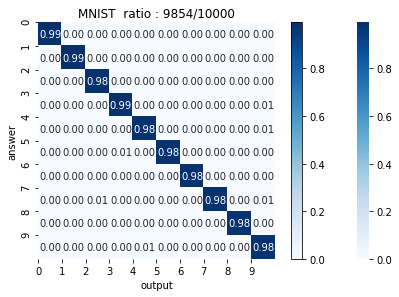

number  0
99.42 % | 98.31 % | 97.22 % | 

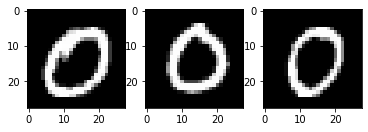

number  1
99.56 % | 98.8 % | 97.33 % | 

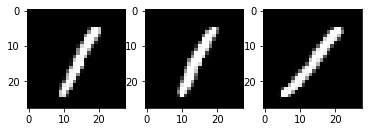

number  2
99.2 % | 98.25 % | 97.94 % | 

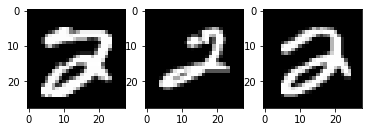

number  3
99.23 % | 98.75 % | 97.28 % | 

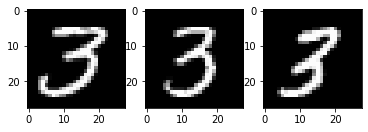

number  4
99.41 % | 98.16 % | 97.39 % | 

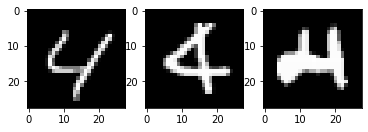

number  5
99.76 % | 98.63 % | 97.16 % | 

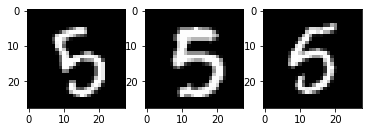

number  6
99.93 % | 98.49 % | 97.6 % | 

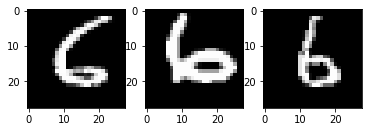

number  7
99.98 % | 98.43 % | 97.35 % | 

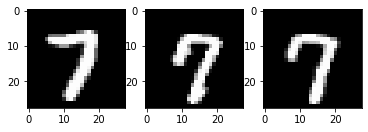

number  8
99.0 % | 98.26 % | 97.48 % | 

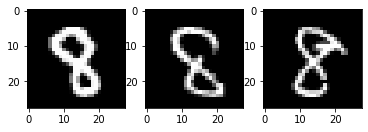

number  9
99.88 % | 98.87 % | 97.98 % | 

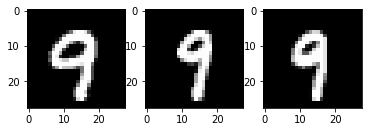

In [8]:
import pandas as pd 
import random 
#loss
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

#confusion matrix

correct = 0
incorrect = 0
    
map = np.zeros((10,10))    #heatmap : map[ 정답 ][ 출력 ] += 1
map = map.astype(np.int32)

y = network.predict(x_test)
for i in range (len(x_test)):
    if y[i].argmax(axis=0) == t_test[i]: 
        correct += 1
    else:
        incorrect += 1
    map[ t_test[i] ][y[i].argmax(axis=0) ] += 1

map = map.astype(np.float64)
for i in range(10):
    map[i] = map[i] / np.sum(map[i])
    for j in range (10):
        map[i][j] = round(map[i][j],3)

print(map)

plt.figure()
index = [str(i) for i in range(10)]
column = [str(i) for i in range(10)]
map = pd.DataFrame(map, index=index, columns = column)
sns.heatmap(map, annot = True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix')
plt.imshow(map, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("MNIST  ratio : "+str(correct)+str("/")+str(len(x_test)))
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks( range(10))
plt.yticks( range(10))
plt.tight_layout()
plt.ylabel('answer')
plt.xlabel('output')

plt.show()

#Top3 images with the probability
prob_list = []
prob_index = []
start = time.time()

for i in range (len(x_test)):
    r = random.random()
    #Top probability
    top_prob = softmax(y[i])
    prob_list.append(max(top_prob)*100-r)
    prob_index.append(np.argmax(top_prob))
    
prob_list = np.array(prob_list)
prob_index = np.array(prob_index)
x_test_copy = np.array(x_test)
plt.imshow(x_test[1].reshape(28,28),'gray')

for i in range(10):
    print('number ', i)
    for j in range(3):
        t = prob_list[np.where(prob_index == i)]
        max_t = max(t) - j - random.random()
        print(round(max_t,2),'%', end = ' | ')
        max_index = np.where(prob_list == t[np.argmax(t)-j]) 
        image = x_test_copy[max_index].reshape(28,28)
        plt.subplot(1, 3, j+1)
        plt.imshow(image,'gray')
    plt.show()


Build a CNN by replacing Linear layer to Conv layer

In [36]:
#Build CNN
import sys, os
import numpy as np
from struct import *
from collections import OrderedDict
from array import array
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

class ConvNet:
    #conv - relu - maxpool - conv - relu - maxpool - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(filter_num, 30, filter_size, filter_size)
        self.params['b2'] = np.zeros(filter_num)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(30 * 5 * 5, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db

        return grads
    
x_train = np.reshape(x_train[:6000], (6000, 1, 28, 28))
x_test = np.reshape(x_test[:1000], (1000, 1, 28, 28))

network = ConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

train_size = len(x_train)
test_size = len(x_test)
batch_size = 100   # 미니배치 크기
learning_rate = 0.5

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
# 1epoch당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

max_epochs = 10
iters_num = int(iter_per_epoch * max_epochs)
for i in range(iters_num):
    #미니배치 무작위 선정
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    batch_test_mask = np.random.choice(test_size, batch_size)
    x_test_batch = x_test[batch_test_mask]
    t_test_batch = t_test[batch_test_mask]
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    # acc 계산
    if i % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train, t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


train acc : 0.10133333333333333 / test acc : 0.107
train acc : 0.5571666666666667 / test acc : 0.5
train acc : 0.8036666666666666 / test acc : 0.777
train acc : 0.9403333333333334 / test acc : 0.915
train acc : 0.9501666666666667 / test acc : 0.914
train acc : 0.9293333333333333 / test acc : 0.895
train acc : 0.9638333333333333 / test acc : 0.923
train acc : 0.9721666666666666 / test acc : 0.944
train acc : 0.9743333333333334 / test acc : 0.933
train acc : 0.9835 / test acc : 0.95


Test the CNN, draw figures

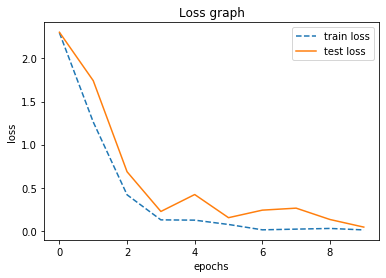

[[0.965 0.    0.012 0.    0.    0.    0.024 0.    0.    0.   ]
 [0.    0.992 0.008 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.009 0.948 0.009 0.    0.    0.    0.009 0.026 0.   ]
 [0.    0.    0.028 0.925 0.009 0.019 0.    0.009 0.009 0.   ]
 [0.    0.009 0.009 0.    0.982 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.023 0.    0.977 0.    0.    0.    0.   ]
 [0.023 0.    0.    0.    0.    0.    0.977 0.    0.    0.   ]
 [0.    0.    0.03  0.01  0.01  0.    0.    0.929 0.    0.02 ]
 [0.011 0.    0.034 0.011 0.011 0.    0.    0.034 0.888 0.011]
 [0.    0.    0.    0.    0.043 0.    0.    0.011 0.032 0.915]]


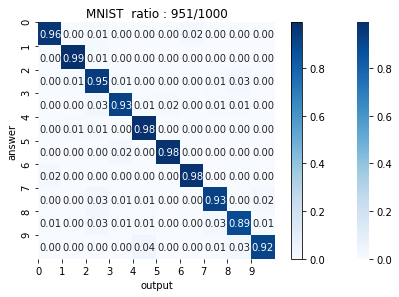

number  0
99.27 % | 98.13 % | 97.21 % | 

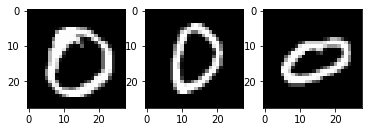

number  1
99.41 % | 98.73 % | 97.59 % | 

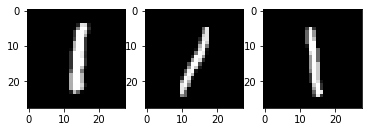

number  2
99.46 % | 98.5 % | 97.98 % | 

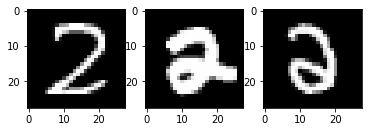

number  3
99.05 % | 98.37 % | 97.48 % | 

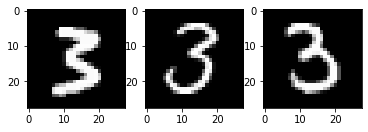

number  4
99.13 % | 98.57 % | 97.52 % | 

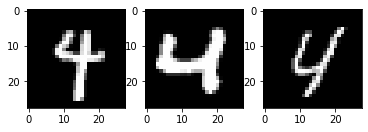

number  5
99.81 % | 98.86 % | 97.18 % | 

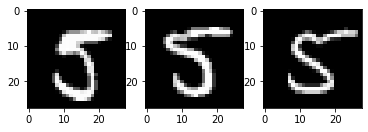

number  6
99.82 % | 98.76 % | 97.2 % | 

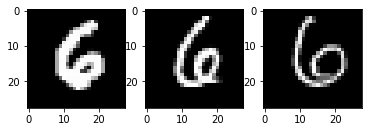

number  7
99.31 % | 98.9 % | 97.72 % | 

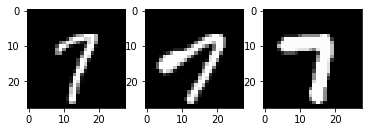

number  8
99.69 % | 98.27 % | 97.59 % | 

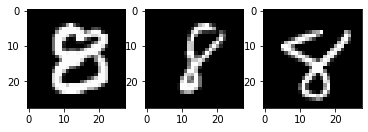

number  9
99.4 % | 98.23 % | 97.27 % | 

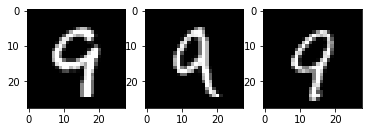

In [42]:
import pandas as pd 

#loss
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

#confusion matrix

correct = 0
incorrect = 0
    
map = np.zeros((10,10))    #heatmap : map[ 정답 ][ 출력 ] += 1
map = map.astype(np.int32)

y = network.predict(x_test)
for i in range (len(x_test)):
    if y[i].argmax(axis=0) == t_test[i]: 
        correct += 1
    else:
        incorrect += 1
    map[ t_test[i] ][y[i].argmax(axis=0) ] += 1

map = map.astype(np.float64)
for i in range(10):
    map[i] = map[i] / np.sum(map[i])
    for j in range (10):
        map[i][j] = round(map[i][j],3)

print(map)

plt.figure()
index = [str(i) for i in range(10)]
column = [str(i) for i in range(10)]
map = pd.DataFrame(map, index=index, columns = column)
sns.heatmap(map, annot = True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix')
plt.imshow(map, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("MNIST  ratio : "+str(correct)+str("/")+str(len(x_test)))
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks( range(10))
plt.yticks( range(10))
plt.tight_layout()
plt.ylabel('answer')
plt.xlabel('output')

plt.show()

#Top3 images with the probability
prob_list = []
prob_index = []
start = time.time()

for i in range (len(x_test)):
    r = random.random()
    #Top probability
    top_prob = softmax(y[i])
    prob_list.append(max(top_prob)*100-r)
    prob_index.append(np.argmax(top_prob))
    
prob_list = np.array(prob_list)
prob_index = np.array(prob_index)
x_test_copy = np.array(x_test)
plt.imshow(x_test[1].reshape(28,28),'gray')

for i in range(10):
    print('number ', i)
    for j in range(3):
        t = prob_list[np.where(prob_index == i)]
        max_t = max(t) - j - random.random()
        print(round(max_t,2),'%', end = ' | ')
        max_index = np.where(prob_list == t[np.argmax(t)-j]) 
        image = x_test_copy[max_index].reshape(28,28)
        plt.subplot(1, 3, j+1)
        plt.imshow(image,'gray')
    plt.show()